In [1]:
import sys
import os

import numpy as np
from matplotlib import pyplot as plt
from sqlalchemy.dialects.mssql.information_schema import columns

sys.path.append(os.path.abspath(".."))

import importlib
import pandas as pd

import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs
import volpy_func_ticker_lib as vtp

importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)
importlib.reload(vtp)

os.makedirs("figures/Analysis", exist_ok=True)
os.makedirs("figures/Analysis/Profitability", exist_ok=True)
os.makedirs("figures/Analysis/Factor models", exist_ok=True)
os.makedirs("figures/Analysis/Implementability", exist_ok=True)
os.makedirs("figures/Analysis/Period", exist_ok=True)

In [2]:
od_rdy = vtp.concat_output_ticker_datasets(vp.All_tickers, df_name="od_rdy")

In [4]:
od_rdy.shape

(178640674, 27)

In [ ]:
od_rdy[]

In [ ]:
od_rdy

In [ ]:
od_rdy = od_raw.copy()

In [ ]:
od_raw = vtp.concat_output_ticker_datasets(vp.All_tickers, df_name="od_raw")

# Min var and Max SR portfolio optimization

In [55]:
orpy = vtp.concat_ticker_datasets(["SPX"], df_name="orpy")
df = vp.make_df_strats(orpy, sgy_common = "r_D_30_", sgy_names = [], factors=["SPX", "SMB", "HML", "RMW", "CMA", "UMD", "BAB", "QMJ", "RF"], ticker_list = ["SPX"], extra_scale_columns=["r_30_SW_day .20", "ln RV/SW 30"], sign=True, scale=True)
df.rename(columns={"r_30_SW_day .20": "VRP"}, inplace=True)
df.rename(columns={"ln RV/SW 30": "LVRP"}, inplace=True)

df_VRP = df[["VRP", "SPX", "SMB", "HML", "RMW", "CMA", "UMD", "BAB", "QMJ"]]
df_LVRP = df[["LVRP", "SPX", "SMB", "HML", "RMW", "CMA", "UMD", "BAB", "QMJ"]]

cols = df_LVRP.columns.difference(['LVRP'])
df_LVRP[cols] = (
    np.log1p(df_LVRP[cols])          # log(1 + r_t)
      .rolling(window=21, min_periods=21)
      .sum()                         # 21-day rolling sum
      .shift(21)                     # move it 21 rows “back” in time¹
)
df_LVRP.rename(columns={"LVRP": "VRP"}, inplace=True)

df_VRP.dropna(inplace = True)
df_LVRP.dropna(inplace = True)

C:\Users\User\AppData\Local\Temp\ipykernel_16616\4164475864.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LVRP[cols] = (
C:\Users\User\AppData\Local\Temp\ipykernel_16616\4164475864.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_LVRP.rename(columns={"LVRP": "VRP"}, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_16616\4164475864.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [56]:
def min_var_and_max_sharpe_weights(df: pd.DataFrame):
    μ   = df.mean()        # expected excess return vector
    Σ   = df.cov()         # sample covariance matrix
    Σ_inv = np.linalg.inv(Σ.values)
    one_vec   = np.ones(len(μ))

    # Minimum-variance: w ∝ Σ_invone_vec, scaled so Σ w = 1
    w_minvar = Σ_inv @ one_vec
    w_minvar = w_minvar / (one_vec @ Σ_inv @ one_vec)

    # Maximum-Sharpe (tangency): w ∝ Σ_invμ, scaled so Σ w = 1
    w_tan = Σ_inv @ μ.values
    w_tan = w_tan / (one_vec @ Σ_inv @ μ.values)

    # Return nicely-labeled Series
    return (pd.Series(w_minvar, index=df.columns, name="Min-Var Weight"),
            pd.Series(w_tan,    index=df.columns, name="Max-Sharpe Weight"))

In [59]:
w_L_min, w_L_tan = min_var_and_max_sharpe_weights(df_LVRP)   # LVRP Min-Var & Max-SR
w_V_min, w_V_tan = min_var_and_max_sharpe_weights(df_VRP)    # VRP  Min-Var & Max-SR

# 2. build the combined dataframe  (each row sums to 1)
weights_df = pd.concat(
    [w_L_min, w_L_tan, w_V_min, w_V_tan],             # series to stack
    axis=1                                            # align on asset names
).T                                                  # portfolios as rows
weights_df.index = ['LVRP_MinVar', 'LVRP_MaxSR',
                    'VRP_MinVar',  'VRP_MaxSR']

# optional: nicer printout / export
weights_df = weights_df.round(4)     # drop or tweak precision as you like

In [61]:
def weights_to_latex(df, digits: int = 4) -> str:
    def _escape(s: str) -> str:              # protect underscores, %, …
        return (str(s)
                .replace('\\', r'\textbackslash ')
                .replace('_',  r'\_')
                .replace('%',  r'\%'))

    cols   = [_escape(c) for c in df.columns]
    ncols  = len(cols)
    body   = []

    # top merged header
    body.append(r'\begin{tabular}{l' + 'r'*ncols + r'}')
    body.append(r'\toprule')
    body.append(r'\multicolumn{' + str(ncols + 1) + r'}{c}{SW}\\')
    body.append(r'\cmidrule(lr){2-' + str(ncols + 1) + r'}')

    # second header line with asset names
    body.append('SW & ' + ' & '.join(cols) + r' \\')
    body.append(r'\midrule')

    # data rows (booktabs-style rule after the LVRP block)
    for i, (idx, row) in enumerate(df.iterrows()):
        vals = ' & '.join(f'{x:.{digits}f}' for x in row)
        body.append(f'{_escape(idx)} & {vals} \\\\')
        if i == 1:                            # after the 2nd row (0-based)
            body.append(r'\midrule')

    # finish
    body.append(r'\bottomrule')
    body.append(r'\end{tabular}')

    return '\n'.join(body)


In [62]:
latex_table = weights_to_latex(weights_df)
print(latex_table)


\begin{tabular}{lrrrrrrrrr}
\toprule
\multicolumn{10}{c}{SW}\\
\cmidrule(lr){2-10}
SW & VRP & SPX & SMB & HML & RMW & CMA & UMD & BAB & QMJ \\
\midrule
LVRP\_MinVar & 0.6721 & 0.1071 & 0.0598 & 0.0108 & 0.0034 & 0.0323 & 0.0475 & -0.0079 & 0.0748 \\
LVRP\_MaxSR & 0.8053 & 0.0749 & 0.0311 & -0.0256 & -0.0023 & 0.0365 & 0.0125 & 0.0077 & 0.0600 \\
\midrule
VRP\_MinVar & 0.0063 & 0.2610 & 0.1795 & 0.1064 & 0.0224 & 0.0421 & 0.0931 & 0.1161 & 0.1730 \\
VRP\_MaxSR & 0.1216 & 0.2491 & 0.1454 & -0.0128 & 0.0315 & 0.0821 & -0.0436 & 0.2029 & 0.2238 \\
\bottomrule
\end{tabular}


# Profitability figures

In [4]:
sum_df = vtp.concat_ticker_datasets(vp.All_tickers, df_name="sum1")
# sum_df["ln RV/SW 30"] = np.log(sum_df["RV"]) - np.log(sum_df["SW_0_30"])

Skipped 2/237 tickers: ['RUT', 'INDU']


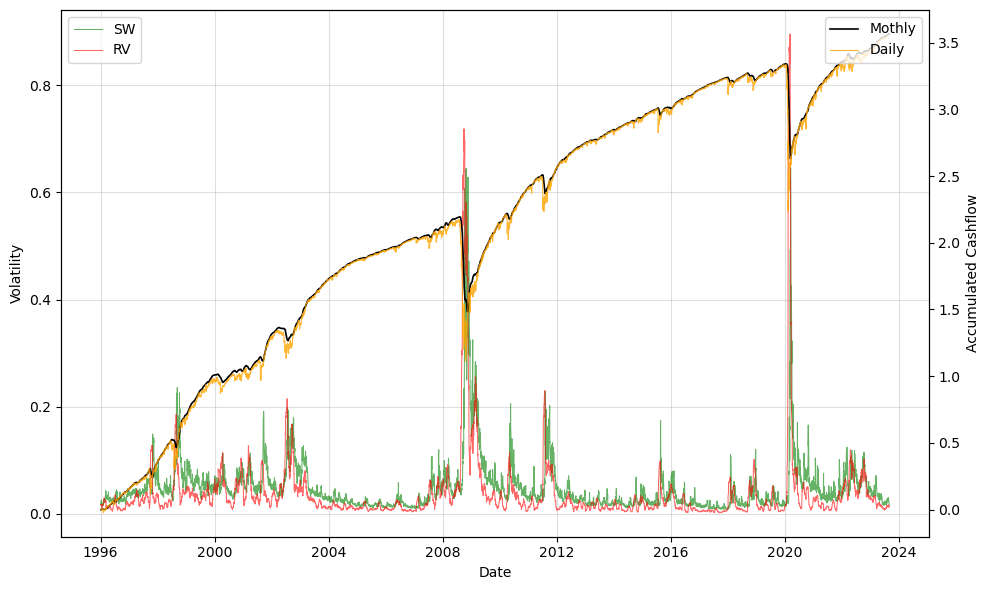

In [60]:
df = sum_df[sum_df["ticker"] == "SPX"].copy()


# plt.figure(figsize=(8,4))
fig, ax1 = plt.subplots(figsize=(10, 6))
# plot the first series on ax1
ax1.plot(df["date"], df["SW_0_30"], alpha=0.6, lw=0.75, label="SW", color = "green")
ax1.plot(df["date"], df["RV"],      alpha=0.6, lw=0.75, label="RV", color = "red")
ax1.set_ylabel("Volatility")
ax1.legend(loc="upper left")
ax1.grid(alpha=0.4)

# create second y-axis
ax2 = ax1.twinx()
# plot cumulative cashflows on ax2
ax2.plot(df["date"], 1/21 * np.cumsum(df["SW_0_30"] - df["RV"]), alpha=1, lw=1.2, linestyle="solid", label="Mothly", color = "black")
ax2.plot(df["date"], np.cumsum(-df["CF_30_SW_day"]).shift(-21),   alpha=0.8, lw=0.8, linestyle="solid", label="Daily", color = "orange")
ax2.set_ylabel("Accumulated Cashflow")
ax2.legend(loc="upper right")

ax1.set_xlabel("Date")

plt.tight_layout()
plt.savefig("figures/Analysis/Profitability/RV_SW_acc.pdf")
plt.show()

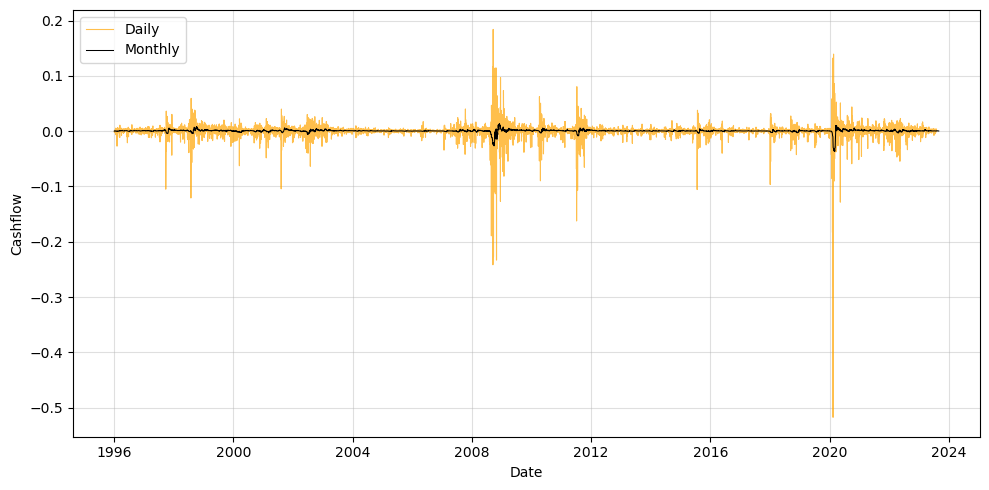

In [59]:
df = sum_df[sum_df["ticker"] == "SPX"].copy()


# plt.figure(figsize=(8,4))
plt.figure(figsize=(10, 5))
# plot the first series on ax1
plt.plot(df["date"], (-df["CF_30_SW_day"]).shift(-21),   alpha=0.7, lw=0.8, linestyle="solid", label="Daily", color = "orange")
plt.plot(df["date"], 1/21 * (df["SW_0_30"] - df["RV"]),      alpha=1, lw=0.75, label="Monthly", color = "black")
plt.legend(loc="upper left")
plt.grid(alpha=0.4)
plt.ylabel("Cashflow")
plt.xlabel("Date")

plt.tight_layout()
plt.savefig("figures/Analysis/Profitability/RV_SW_change.pdf")
plt.show()

# Profitability test

In [7]:
sum_df = vtp.concat_ticker_datasets(vp.All_tickers, df_name="sum1", folder_version="_om")

Skipped 2/237 tickers: ['RUT', 'INDU']


In [18]:
importlib.reload(vtp)
importlib.reload(table_lib)

ticker_list_list = [vp.VIX_tickers, vp.Cross_AM_tickers, vp.OEX_tickers, vp.Liquid_tickers, vp.DJX_tickers]
name_list = ["VIX", "Cross-AM", "OEX", "Liquid", "DJX"]

# ticker_list_list = [vp.Cross_AM_tickers]
# name_list = ["Cross-AM"]

# sum_df["ln r_SW_day"] = sum_df["r_30_SW_day .20"]

# ticker_list_list = [vp.Liquid_tickers]
# name_list = ["Liquid"]

for ticker_list, name in zip(ticker_list_list, name_list):
    df = sum_df[sum_df["ticker"].isin(ticker_list)].copy()
    # sum_df = sum_df[(sum_df['date'] <= pd.Timestamp('2003-02-28'))]
    # sum_df = sum_df[(sum_df['date'] > pd.Timestamp('2003-02-28'))]
    d1 = table_lib.CarrWu2009_table_2(df, name)
    d2 = table_lib.CarrWu2009_table_3(df, name)
    # d3_old = table_lib.table_3_daily(sum_df, name) # MA version
    d3 = table_lib.table_3_daily_EWMA(df, name, 0.2)
    
    if name == "OEX" or name == "DJX":
        df = sum_df[sum_df["ticker"].isin(ticker_list+["SPX"])].copy()
    d4 = table_lib.vol_period_analysis(df, name, split_method='quantile')
    d5 = table_lib.vol_period_analysis(df, name, split_method='time')

In [19]:
sum_df = vtp.concat_ticker_datasets(vp.All_tickers, df_name="sum1", folder_version="_om")

Skipped 2/237 tickers: ['RUT', 'INDU']


In [24]:
SPX_df = sum_df[sum_df["ticker"] == "SPX"].copy()

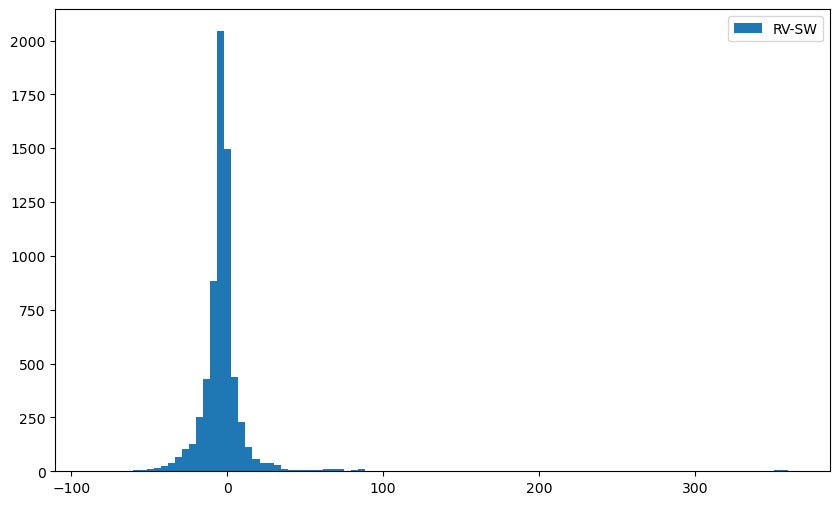

In [39]:
df = sum_df[sum_df["ticker"] == "AAPL"].copy()
plt.figure(figsize=(10, 6))
plt.hist(df["RV-SW 30"]*100, bins = 100, label = "RV-SW")
plt.legend()
plt.show()

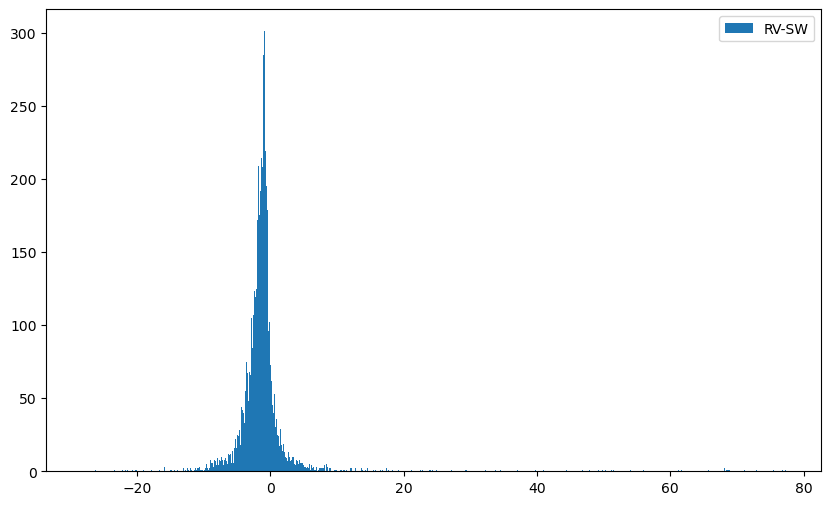

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(SPX_df["RV-SW 30"]*100, bins = 1000, label = "RV-SW")
plt.legend()
plt.show()

In [41]:
sum(SPX_df["RV-SW 30"] > 0.060)

168

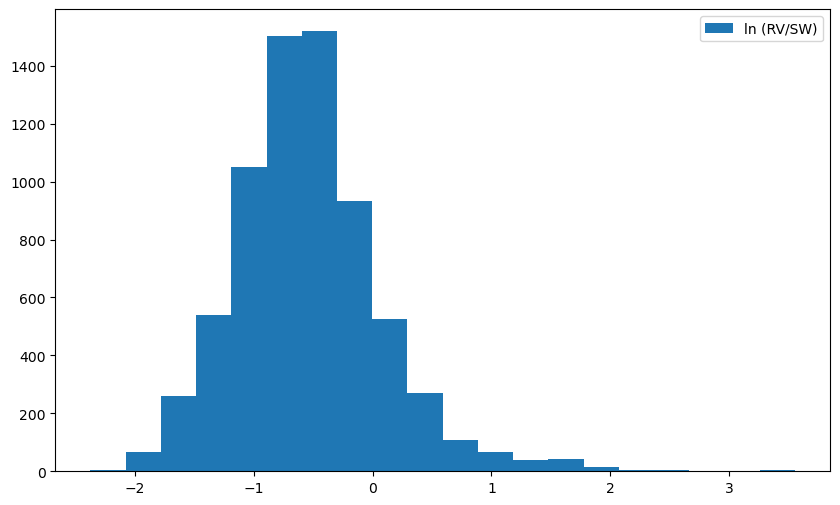

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(SPX_df["ln RV/SW 30"], bins = 20, label = "ln (RV/SW)")
plt.legend()
plt.show()

In [31]:
SPX_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ticker,date,index,#days,low days,high days,low #K,...,EWMA SW .5,r_30_SW_day .5,EWMA SW .10,r_30_SW_day .10,EWMA SW .15,r_30_SW_day .15,EWMA SW .20,r_30_SW_day .20,EWMA SW .25,r_30_SW_day .25
861227,0.0,0,0,SPX,1996-01-04,0,6.0,11.0,31.0,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861228,1.0,1,1,SPX,1996-01-05,1,6.0,10.0,30.0,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861229,2.0,2,2,SPX,1996-01-08,2,6.0,9.0,29.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861230,3.0,3,3,SPX,1996-01-09,3,6.0,8.0,28.0,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
861231,4.0,4,4,SPX,1996-01-10,4,6.0,7.0,27.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868185,6958.0,6958,6958,SPX,2023-08-25,6958,42.0,21.0,21.0,47.0,...,0.023898,-0.172041,0.025390,-0.161932,0.026398,-0.155747,0.026898,-0.152853,0.027129,-0.151552
868186,6959.0,6959,6959,SPX,2023-08-28,6959,42.0,21.0,21.0,45.0,...,0.023871,-0.073769,0.025186,-0.069917,0.025941,-0.067882,0.026189,-0.067241,0.026184,-0.067251
868187,6960.0,6960,6960,SPX,2023-08-29,6960,42.0,21.0,21.0,48.0,...,0.023786,0.003964,0.024884,0.003789,0.025375,0.003716,0.025384,0.003715,0.025180,0.003745
868188,6961.0,6961,6961,SPX,2023-08-30,6961,42.0,21.0,21.0,352.0,...,0.023632,-0.083542,0.024467,-0.080692,0.024675,-0.080010,0.024449,-0.080750,0.024062,-0.082048


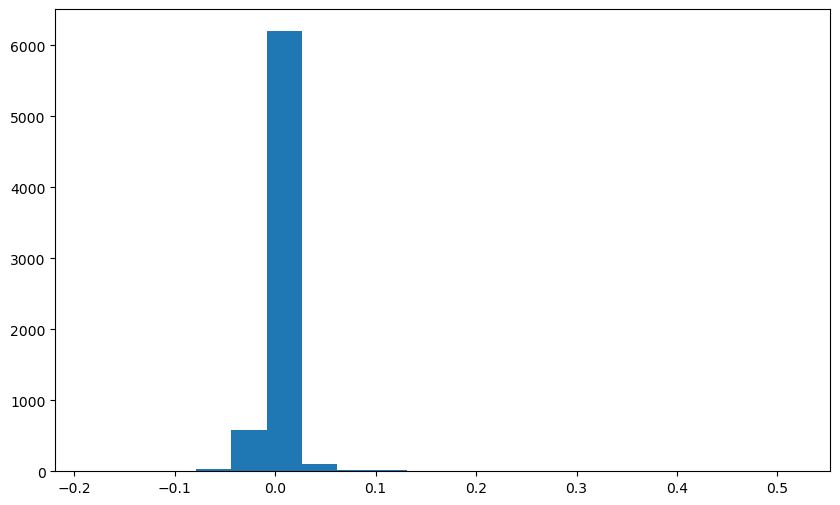

In [30]:
plt.figure(figsize=(10, 6))
plt.hist(SPX_df["CF_30_SW_day"], bins = 20)
plt.show()

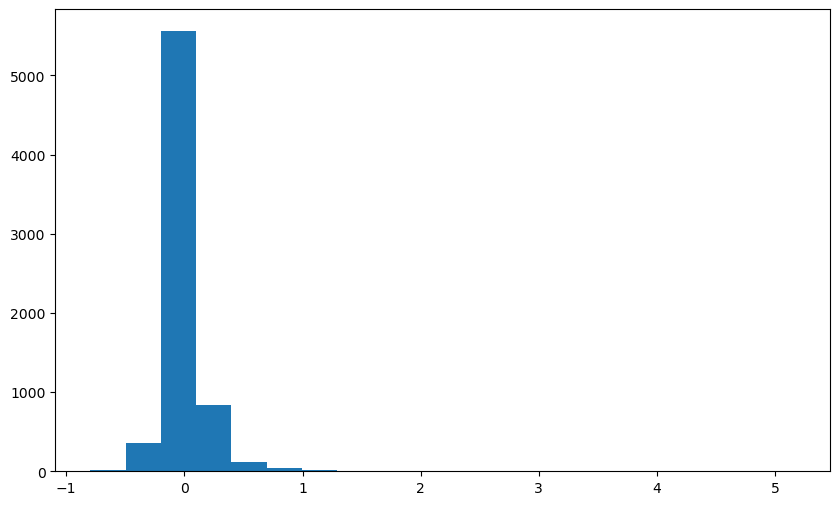

In [32]:
plt.figure(figsize=(10, 6))
plt.hist(SPX_df["r_30_SW_day .20"], bins = 20)
plt.show()

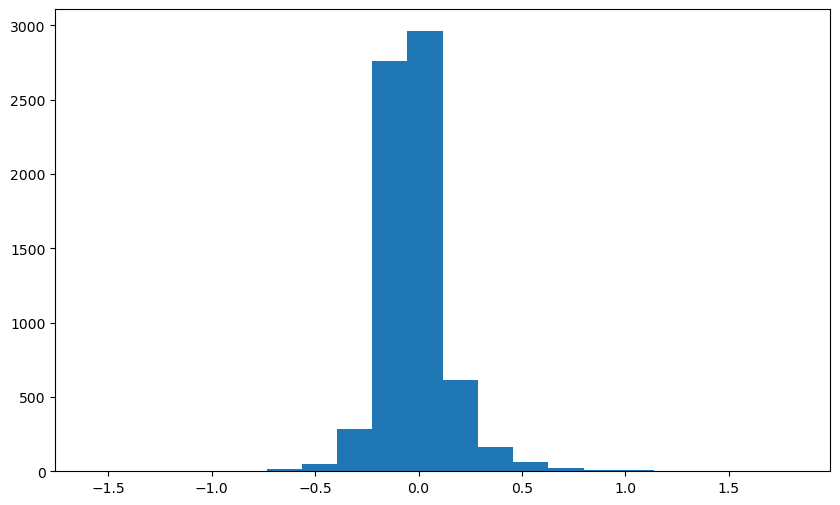

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(np.log(1+SPX_df["r_30_SW_day .20"]), bins = 20)
plt.show()

# Faktor

In [87]:
orpy = vtp.concat_ticker_datasets(vp.All_tickers, "orpy")
orpy["ln RV/SW 30"] = np.log(orpy["RV"]) - np.log(orpy["SW_0_30"])

Skipped 2/237 tickers: ['RUT', 'INDU']


In [88]:
importlib.reload(vtp)
importlib.reload(table_lib)

ticker_list_list = [vp.VIX_tickers, vp.Cross_AM_tickers, vp.OEX_tickers, vp.DJX_tickers, vp.Liquid_tickers]
name_list = ["VIX", "Cross-AM", "OEX", "DJX", "Liquid"]

# ticker_list_list = [vp.Liquid_tickers]
# name_list = ["Liquid"]

for ticker_list, name in zip(ticker_list_list, name_list):
    returns_df = vp.make_df_strats(orpy, sgy_common = "r_D_30_", sgy_names = [], plot = False, factors=["SPX", "Mkt", "SMB", "HML", "UMD", "BAB"], ticker_list= ticker_list, extra_columns=["#K", "RV", "r_30_SW_day .20", "RV-SW 30", "ln RV/SW 30"], sign=False, scale=False)
    #"RV-SW 30"
    # returns_df = returns_df[returns_df["date"] <= pd.Timestamp('2003-02-28')].copy()

    df2 = table_lib.save_ff3_table_dly_mly(returns_df, name)

    for y_var, max_lags in zip(["r_30_SW_day .20", "ln RV/SW 30"], [None, 21]):    
        df1 = table_lib.save_capm_table(returns_df, name, max_lags = max_lags, y_var = y_var)
        df3 = table_lib.save_ff5_table(returns_df, name, max_lags = max_lags, y_var = y_var)

# Performance

In [240]:
importlib.reload(table_lib)
importlib.reload(vp)

orpy_SPX = vtp.concat_ticker_datasets(["SPX"], "orpy")
orpy_SPX = orpy_SPX.dropna(subset=["r_30_SW_day .20"])

returns_df = vp.make_df_strats(orpy_SPX, sgy_common = "CF_D_30_", sgy_names = ["straddle", "call_ATM", "strangle_15%"], factors=["SPX", "Mkt", "SMB", "HML", "RMW", "CMA", "UMD", "BAB"], ticker_list = ["SPX"], extra_scale_columns=["r_30_SW_day .20"], sign=True, scale=True)

sgys = ["CF_30_SW_day", "CF_D_30_straddle", "SPX", "SMB", "HML", "RMW", "CMA", "UMD", "BAB"] #, "date"
df = returns_df[sgys]
df = df.dropna()

df.rename(columns={'CF_30_SW_day': 'SW', 'CF_D_30_straddle': "Straddle"}, inplace=True)

df = vp.scale_columns_to_r_stock_std_dev(df, df.columns, std = 0.2/252**0.5)
df = vp.compute_extensive_performance_measures_cashflows(df, cvar_alpha=0.01).T.reset_index()

latex_code = table_lib.df_to_panel_latex(
    df,
    variable_name="Factor/Strategy",
    caption="Performance measures for the daily variance‐swap rolling strategy and the daily rolling straddle strategy, compared to the daily returns of the equity factors: the Fama–French five factors, momentum (UMD), and betting‐against‐beta (BAB).",
    label="tab:performance_by_strategy_relative_to_risk_factors",
    float_fmt="{:.2f}"
)
with open("figures/Analysis/Implementability/performance_relative_to_factors.tex", 'w') as f:
    f.write(latex_code)

In [241]:
df

,index,Mean,SD,Skew,Kurt,Auto(1),VaR 1\%,CVaR 1\%,Max DD,Sharpe,Sortino,Calmar,Win,P/L,Tail 5\%,Tail 1\%,Tail 0.1\%
0,SW,10.599359,20.0,-920.090175,25000.578394,-16.356690,-54.986416,-121.921133,-90.818479,52.996794,39.732974,11.670927,64.771251,64.431657,100.335366,72.451224,53.238164
1,Straddle,11.839999,20.0,-611.222703,11392.512139,-11.499548,-64.822954,-123.301973,-115.138575,59.199995,46.978613,10.283260,64.670227,63.438971,85.038244,67.661710,57.770052
2,SPX,9.465959,20.0,-17.791032,953.525722,-9.560915,-55.232656,-79.783978,-73.795476,47.329795,60.800697,12.827289,53.528648,94.886730,93.728283,100.140609,93.834262
3,SMB,2.742390,20.0,0.202315,385.189314,1.058536,-49.573021,-67.661702,-111.426519,13.711950,20.383412,2.461165,50.613364,98.386273,98.979592,104.101911,83.072454
4,HML,2.701494,20.0,29.074693,709.364750,3.547518,-55.890601,-77.370680,-117.685166,13.507471,18.847436,2.295527,48.996969,104.909629,103.521127,111.899831,112.015245
5,RMW,11.123052,20.0,26.670972,528.401290,11.453403,-55.304532,-72.281092,-126.516544,55.615259,80.823374,8.791777,50.396883,106.590814,107.594937,102.739726,114.587935
6,CMA,6.740524,20.0,-39.807355,819.108994,6.971233,-54.920022,-78.194482,-77.720462,33.702618,46.176947,8.672779,48.968105,107.852184,113.636364,99.649235,86.525709
7,UMD,5.042333,20.0,-113.254177,1252.316438,13.380773,-64.648839,-91.929728,-116.386970,25.211664,29.117887,4.332386,54.149228,87.599708,94.473684,80.419750,79.732858
8,BAB,12.306400,20.0,-46.840933,1033.199724,2.625270,-62.552334,-88.247742,-132.278892,61.531998,74.542637,9.303374,54.553327,93.793871,103.340603,85.905775,87.667881


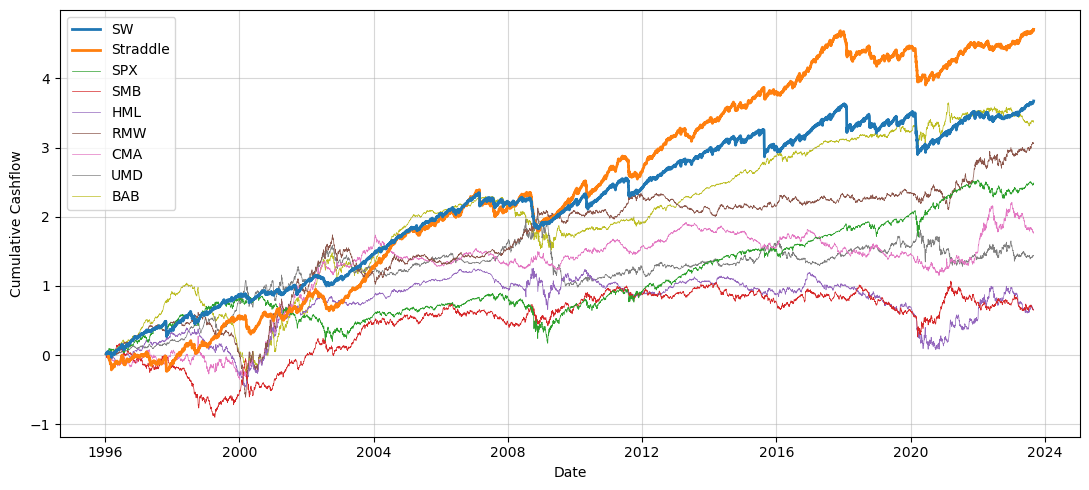

In [89]:
importlib.reload(table_lib)
importlib.reload(vp)

orpy_SPX = vtp.concat_ticker_datasets(["SPX"], "orpy")
orpy_SPX["ln RV/SW 30"] = np.log(orpy_SPX["RV"]) - np.log(orpy_SPX["SW_0_30"])
orpy_SPX = orpy_SPX.dropna(subset=["r_30_SW_day .20"])

returns_df = vp.make_df_strats(orpy_SPX, sgy_common = "r_D_30_", sgy_names = ["straddle", "call_ATM", "strangle_15%"], factors=["SPX", "Mkt", "SMB", "HML", "RMW", "CMA", "UMD", "BAB"], ticker_list = ["SPX"], extra_scale_columns=["r_30_SW_day .20"], sign=True, scale=True)

returns_df.rename(columns={'r_30_SW_day .20': 'SW', 'r_D_30_straddle': "Straddle"}, inplace=True)
sgys = ["SW", "Straddle", "SPX", "SMB", "HML", "RMW", "CMA", "UMD", "BAB"] 
df = returns_df[sgys + ["date"]]
df = df.dropna()


df['date'] = pd.to_datetime(df['date'])

plt.figure(figsize=(11,5))
for idx, sgy in enumerate(sgys):
    # standard line‐width logic
    lw = 2 if sgy in ("SW","Straddle") else 0.5
    # z-order: first in sgys (idx=0) gets highest z, last gets lowest
    z = len(sgys) - idx
    plt.plot(df['date'], np.cumsum(df[sgy]), label=sgy, lw=lw, zorder=z)

plt.legend()
plt.xlabel('Date')
plt.ylabel('Cumulative Cashflow')
# plt.title('Strategy Cashflows relative to factors')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.savefig("figures/Analysis/Implementability/figure_performance_relative_to_factors.pdf")
plt.show()

# Implementability

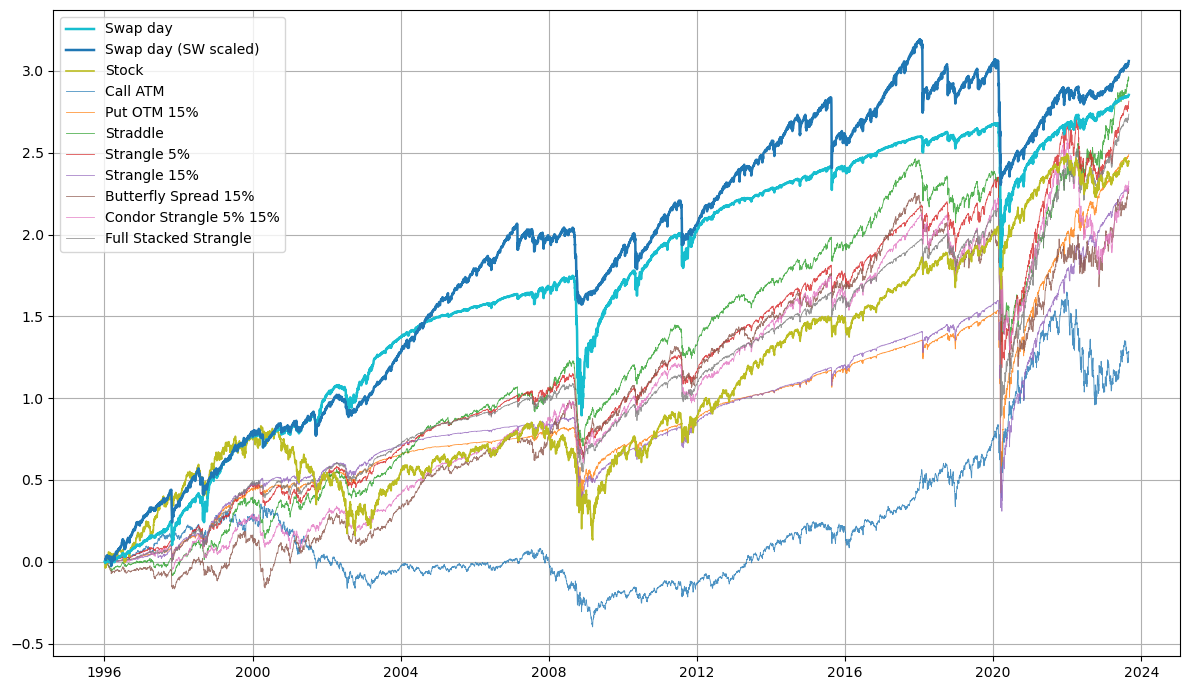

In [90]:
importlib.reload(vp)
orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

sgy_names = ["call_ATM", "put_OTM_15%", "straddle", "strangle_5%", "strangle_15%", "butterfly_spread_15%", "condor_strangle_5%_15%", "full_stacked_strangle"]
df_returns = vp.make_df_strats(orpy, sgy_common = "CF_30_", sgy_names = sgy_names, factors=[], ticker_list = ["SPX"], sign=True, scale=True, 
                               plot = True, figsize=(12,7), lw = 0.6, fig_name = "figures/Analysis/Implementability/strategies.pdf")

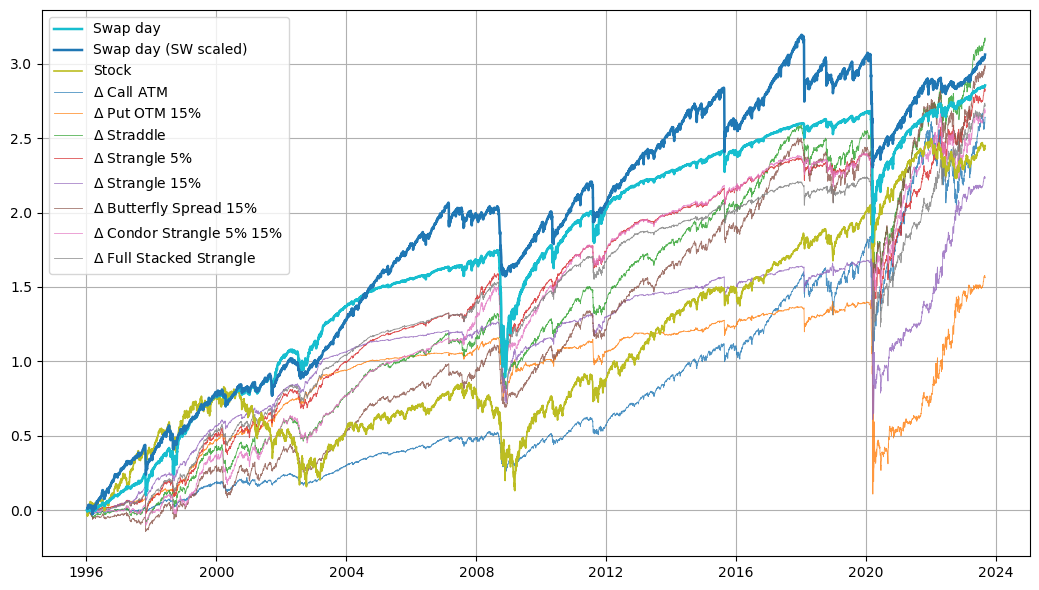

In [91]:
importlib.reload(vp)
orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

sgy_names = ["call_ATM", "put_OTM_15%", "straddle", "strangle_5%", "strangle_15%", "butterfly_spread_15%", "condor_strangle_5%_15%", "full_stacked_strangle"]
df_returns = vp.make_df_strats(orpy, sgy_common = "CF_D_30_", sgy_names = sgy_names, factors=[], ticker_list = ["SPX"], sign=True, scale=True, 
                               plot = True, figsize=(10.5,6), lw = 0.6, fig_name = "figures/Analysis/Implementability/D_strategies.pdf", prefix = r"$\Delta$ ")

# Performance table

In [245]:
import re

importlib.reload(table_lib)
importlib.reload(vp)

orpy_x = vtp.concat_ticker_datasets(["SPX"], "orpy")

input_sgy_list = ["call_ATM","put_OTM_15%","straddle","strangle_5%",
        "strangle_15%","butterfly_spread_15%","condor_strangle_5%_15%",
        "full_stacked_strangle"]

# 1) Base run (no D_)
returns_base = vp.make_df_strats(
    orpy_x,
    sgy_common        = "CF_30_",
    sgy_names         = input_sgy_list,
    factors           = [],
    ticker_list       = ["SPX"],
    extra_scale_columns = ["r_30_SW_day .20"],
    sign              = True,
    scale             = True
)

# 2) Delta run (only keep the D_ columns)
returns_delta = vp.make_df_strats(
    orpy_x,
    sgy_common        = "CF_D_30_",
    sgy_names         = input_sgy_list,
    factors           = [],
    ticker_list       = ["SPX"],
    extra_scale_columns = [],
    sign              = True,
    scale             = True
)

# 3) Extract & rename only the CF_D_30_* columns to Δ*
delta_cols = [c for c in returns_delta.columns if c.startswith("CF_D_30_")]
delta_rename_map = {
    c: "Δ " + re.match(r"CF_D_30_(.*)", c).group(1)
    for c in delta_cols
}
delta_trim = returns_delta[list(delta_rename_map) + ["date", "ticker"]] \
             .rename(columns=delta_rename_map)

# 4) Now merge them side-by-side on your index (or on ticker/date if they’re columns)
#    Here I assume ticker & date are columns you want to preserve
df_big = (
    returns_base
      .set_index(["ticker","date"])
      .join(delta_trim.set_index(["ticker","date"]))
      .reset_index()
)


rename_map = {
        'r_30_SW_day .20':  'r SW',
        'CF_30_SW_day':      'CF SW',
        'CF_30_straddle':  'straddle',
        'CF_30_call_ATM':   'call_ATM',
        'CF_30_put_OTM_15%':  'put_OTM_15%',
        'CF_30_strangle_5%':  'strangle_5%',
        'CF_30_strangle_15%':  'strangle_15%',
        'CF_30_butterfly_spread_15%':  'butterfly_spread_15%',
        'CF_30_condor_strangle_5%_15%':  'condor_strangle_5%_15%',
        'CF_30_full_stacked_strangle':  'full_stacked_strangle',
    }

rename_delta_map = {
    col: re.sub(r'^CF_D_30_', '', col)
    for col in returns_df.columns
    if col.startswith('CF_D_30_')
}

# combine and apply
df_big.rename(columns={**rename_map, **rename_delta_map}, inplace=True)
df_big.drop(columns=['r_30_SW_day'], inplace=True)

sgys = ["CF SW", "straddle", "call_ATM", "put_OTM_15%", "strangle_5%", "strangle_15%", "butterfly_spread_15%", "condor_strangle_5%_15%", "full_stacked_strangle"]
delta_sgys = [f"Δ {c}" for c in sgys if c != "CF SW"]


SPX = pd.read_csv("data/factor_df.csv")[["date", "SPX"]]
SPX['date'] = pd.to_datetime(SPX['date'])
df_big = df_big.merge(SPX, on='date', how='left',)

df = df_big[sgys + delta_sgys + ["SPX"]]

df = df.dropna()
df = vp.clean_option_names(df)

df.columns = [col.replace('%', r'\%') for col in df.columns]
df.columns = [col.replace('Δ', r'$\Delta$') for col in df.columns]

df = vp.scale_columns_to_r_stock_std_dev(df, df.columns, std = 0.2/252**0.5)
df_stats = vp.compute_extensive_performance_measures_cashflows(df, include_jensens_alpha = True, cvar_alpha = 0.01).T.reset_index()

latex_code = table_lib.df_to_panel_latex(
    df_stats,
    variable_name = "Option Strategy",
    caption="this is my caption",
    label="tab:analysis:Implementability_option_strategies",
    float_fmt="{:.2f}", 
)
with open("figures/Analysis/Implementability/performance_double_sgys_both.tex", 'w') as f:
    f.write(latex_code)

df_stats

,index,Mean,SD,Skew,Kurt,Auto(1),VaR 1\%,CVaR 1\%,Max DD,Sharpe,Sortino,Calmar,Win,P/L,Tail 5\%,Tail 1\%,Tail 0.1\%,Alpha
0,CF SW,10.684449,20.0,-920.674562,25021.892139,-16.354520,-54.999933,-121.941427,-90.833596,53.422244,40.044530,11.762662,64.780600,64.497130,100.510170,72.447788,53.237838,4.548890
1,Straddle,11.092405,20.0,-486.651778,7811.067436,-5.142778,-69.195746,-120.971352,-118.787461,55.462025,45.492821,9.338027,64.087760,64.160961,84.531495,64.091495,44.440729,8.817975
2,Call ATM,5.026936,20.0,92.636049,1587.342253,-4.767609,-53.276336,-79.249540,-76.323819,25.134682,35.613109,6.586327,47.950346,114.243543,113.583407,119.220891,105.828664,-2.945500
3,Put OTM 15\%,9.400730,20.0,-1427.192724,55703.684021,-33.729050,-50.392710,-111.142657,-115.178333,47.003651,33.907311,8.161891,65.300231,64.152450,120.618686,81.473411,87.303007,3.336945
4,Strangle 5\%,10.504199,20.0,-635.893343,11204.662068,-4.723033,-66.431060,-127.765282,-123.343317,52.520993,39.427244,8.516228,66.657044,57.601728,89.565386,65.724906,43.619178,6.072240
5,Strangle 15\%,8.542798,20.0,-1732.643277,63730.213522,-19.796978,-51.297762,-114.804977,-132.980342,42.713988,29.568720,6.424106,65.603349,62.209235,118.302729,75.425329,66.828050,3.324791
6,Butterfly Spread 15\%,8.685975,20.0,-240.755307,2638.521059,-4.255425,-71.491770,-110.152959,-109.306849,43.429876,39.810962,7.946414,62.297921,66.450913,79.280458,62.739784,62.687106,9.356385
7,Condor Strangle 5\% 15\%,8.845210,20.0,-329.117297,3775.928262,-2.554360,-75.958902,-121.544846,-95.952279,44.226050,36.533857,9.218343,65.040416,59.574954,80.968345,57.229263,48.177599,6.568628
8,Full Stacked Strangle,10.257129,20.0,-1011.550593,25727.963665,-9.496716,-65.651134,-124.857732,-132.019450,51.285645,36.539898,7.769407,67.234411,56.905689,95.662557,62.523161,53.587179,5.313959
9,$\Delta$ Straddle,11.909867,20.0,-611.493094,11398.890780,-11.497192,-64.830628,-123.313131,-115.148995,59.549335,47.245884,10.343006,64.679561,63.471029,85.138752,67.660524,57.771553,8.330244


In [238]:
df["CF SW"].mean()*252

0.10605033651875743

# Test manually (other)

In [ ]:
# importlib.reload(vp)
# ticker_list = ["SPX"]
# orpy = vtp.concat_ticker_datasets(ticker_list, "orpy")
# 
# sgy_names = ["call_ATM", "put_OTM_15%", "straddle", "strangle_5%", "strangle_15%", "butterfly_spread_15%", "condor_strangle_5%_15%", "full_stacked_strangle"]
# df_returns = vp.make_df_strats(orpy, sgy_common = "EWMA r_D_30_", sgy_names = sgy_names, factors=[], ticker_list = ticker_list, sign=True, scale=True, 
#                                plot = True, figsize=(12,7), lw = 0.6)

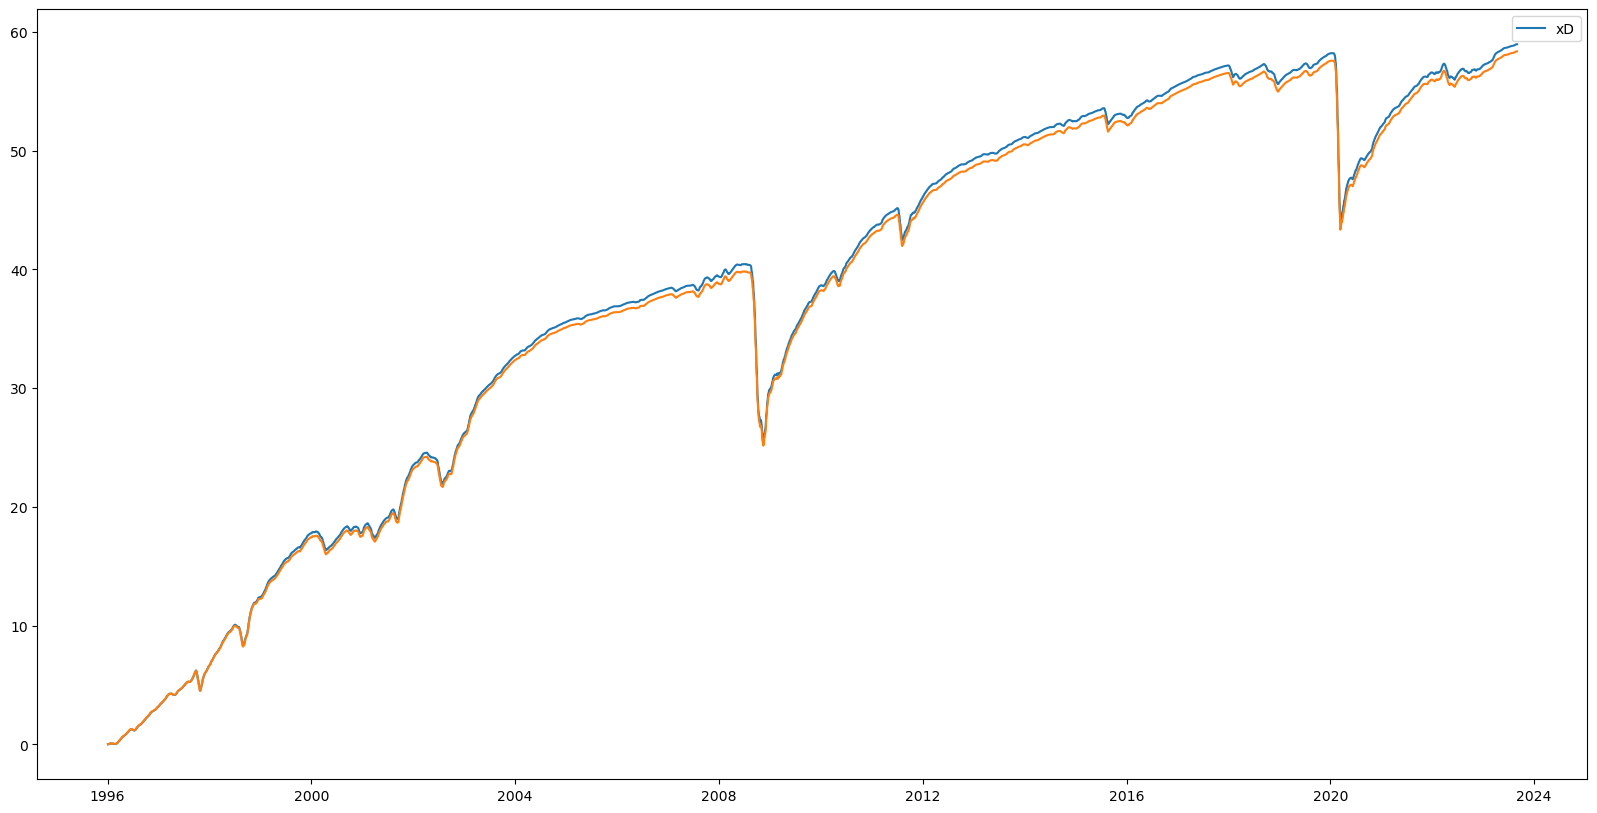

In [10]:
sum_df = vtp.concat_ticker_datasets(["OEX"], df_name="sum1")

plt.figure(figsize=(20,10))
# plt.plot(sum_df["date"], -np.cumsum(sum_df["r_30_SW_day"]))
plt.plot(sum_df["date"], -np.cumsum(sum_df["RV"] - sum_df["SW_0_30"]), label = "xD")
plt.plot(sum_df["date"], -np.cumsum(sum_df["RV"] - sum_df["SW_0_30_linear"]))
plt.legend()

In [14]:
def lm_regress(df, y_column, x_columns, print_summary = True, max_lags = None):
    df = df[df[y_column].isna() == False]

    if max_lags is not None:
        df = df.copy()
        for col in x_columns:
            df[col] = df[col].rolling(window=max_lags).mean().shift(-max_lags)
            df[col] = np.log(df[col]+1)
    
    # drop any rows with NaNs in y or in the newly-averaged x’s
    df = df.dropna(subset=[y_column] + x_columns)
    import statsmodels.api as sm

    
    # Define your target variable and factor variables
    X = df[x_columns]  # Independent variables
    y = df[y_column]   # Dependent variable
    
    # Add a constant term to the independent variables for the intercept
    X = sm.add_constant(X)
    
    # Fit the linear regression model
    if max_lags == None:
        model = sm.OLS(y, X).fit()
    else:
        model = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": max_lags})

    if print_summary:
        # Print the summary statistics
        print(model.summary())

    return model.summary()

In [53]:
df["CF/SW 30"].std()

0.1778102003626736

In [54]:
df["r_30_SW_day .20"].std()

0.2007256314604784

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


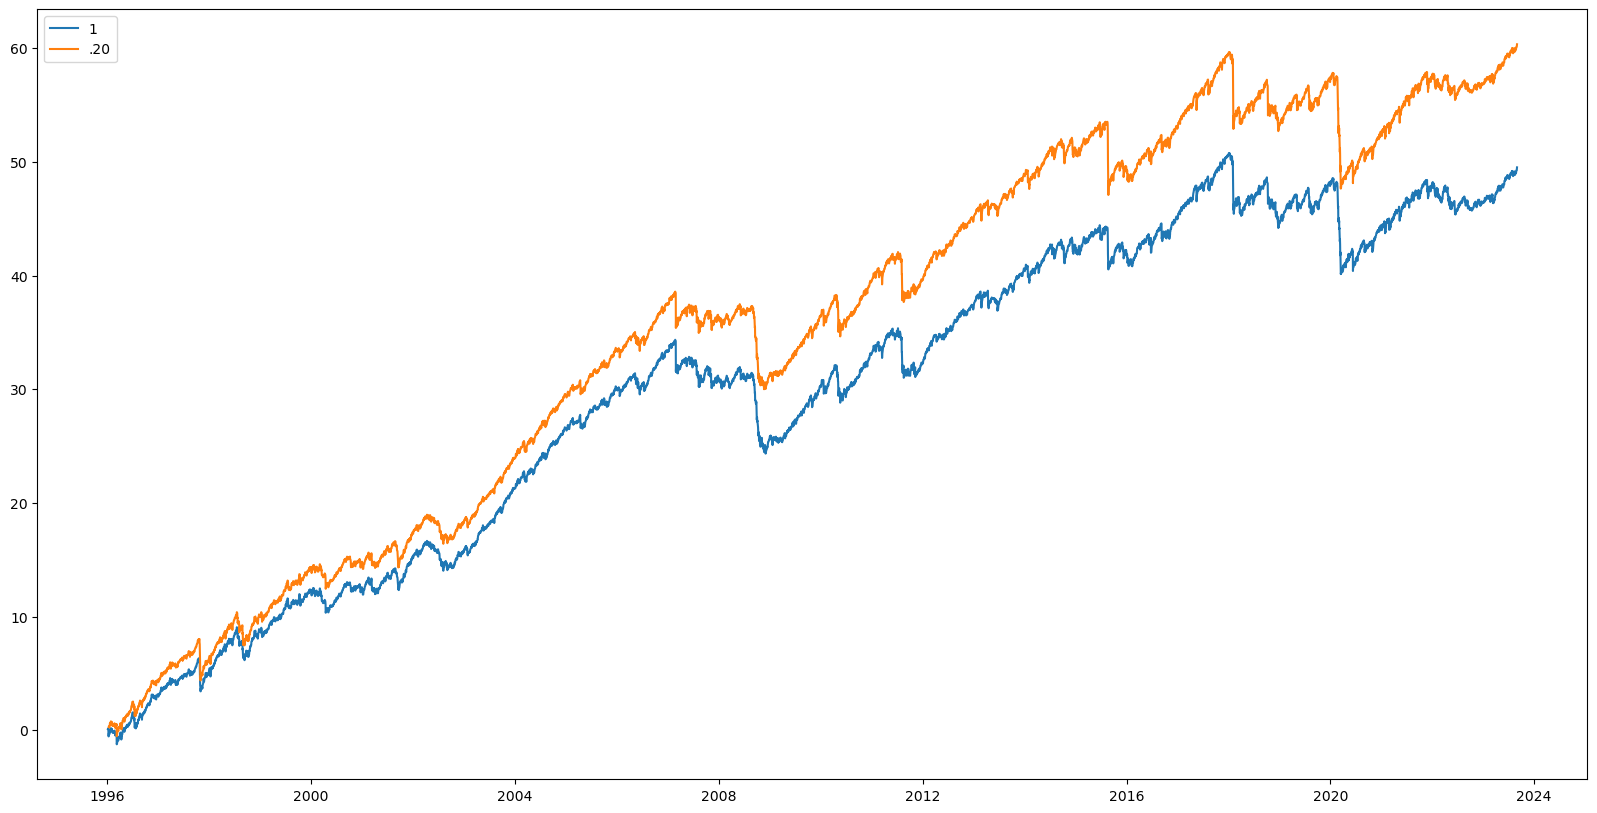

In [47]:
orpy["ln CF/SW 30"] = np.log(orpy["CF_30_SW_day"] / orpy["SW_m1_29"] +1)
orpy["CF/SW 30"] = orpy["CF_30_SW_day"] / orpy["SW_m1_29"]

df = orpy[orpy["ticker"]=="SPX"]

plt.figure(figsize=(20,10))
plt.plot(df["date"], np.cumsum(-df["CF/SW 30"]), label = "1")
plt.plot(df["date"], np.cumsum(-df["r_30_SW_day .20"]), label = ".20")
# plt.plot(df["date"], np.cumsum(df["ln CF/SW 30"]))

plt.legend()

In [23]:
# orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

feature_columns = ["Mkt"] # ["Mkt", "SMB", "HML"] #["Mkt", "SMB", "HML", "BAB", "UMD"] #["Mkt"]

# target_column = 'r_30_SW_day .20'
target_column = 'RV-SW 30'

orpy["ln RV/SW 30"] = np.log(orpy["RV"]+1) - np.log(orpy["SW_0_30"]+1)
orpy["ln CF/SW 30"] = np.log(orpy["CF_30_SW_day"] / orpy["SW_0_30"] +1)

target_column = "ln RV/SW 30"
ticker = "SPX"

orpy_period = orpy
# orpy_period = orpy[orpy["date"] <= pd.Timestamp('2003-02-28')].copy()
returns_df = vp.make_df_strats(orpy_period, sgy_common = "r_D_30_", sgy_names = [], plot = False, ticker_list = [ticker], extra_columns=["#K", target_column], sign=True)

df = returns_df[returns_df["ticker"] == ticker]

_ = lm_regress(df, y_column = target_column, x_columns = feature_columns, max_lags = 21)

                            OLS Regression Results                            
Dep. Variable:            ln RV/SW 30   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     21.14
Date:                Thu, 08 May 2025   Prob (F-statistic):           4.35e-06
Time:                        10:14:39   Log-Likelihood:                 13294.
No. Observations:                6942   AIC:                        -2.658e+04
Df Residuals:                    6940   BIC:                        -2.657e+04
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0077      0.002     -3.441      0.0

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [116]:
# orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

feature_columns = ["Mkt", "SMB", "HML", "BAB", "UMD"] # ["Mkt", "SMB", "HML"] #["Mkt", "SMB", "HML", "BAB", "UMD"] #["Mkt"]

# target_column = 'r_30_SW_day .20'
target_column = 'RV-SW 30'

orpy["ln RV/SW 30"] = np.log(orpy["RV"] / orpy["SW_0_30"])
orpy["ln r_SW_day"] = np.log(orpy["r_30_SW_day .20"] + 1)
target_column = "ln r_SW_day"
max_lags = None

target_column = "ln RV/SW 30"
max_lags = 21

ticker = "SPX"

orpy_period = orpy
# orpy_period = orpy[orpy["date"] <= pd.Timestamp('2003-02-28')].copy()
returns_df = vp.make_df_strats(orpy_period, sgy_common = "r_D_30_", sgy_names = [], plot = False, ticker_list = [ticker], extra_columns=["#K", target_column], sign=True)

df = returns_df[returns_df["ticker"] == ticker]

_ = lm_regress(df, y_column = target_column, x_columns = feature_columns, max_lags = max_lags)

                            OLS Regression Results                            
Dep. Variable:            ln RV/SW 30   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     1.092
Date:                Wed, 07 May 2025   Prob (F-statistic):              0.364
Time:                        16:53:26   Log-Likelihood:                -302.26
No. Observations:                 482   AIC:                             616.5
Df Residuals:                     476   BIC:                             641.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1944      0.367     -3.258      0.0

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [129]:
np.log(orpy["RV"] / orpy["SW_0_30"]-1).mean()

C:\ProgramData\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


-1.1739887741031056

In [112]:
df["Average SW"].sort_values().head(20)

KeyError: 'Average SW'

In [115]:
orpy[f"EWMA SW .20"]

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
987587    0.030492
987588    0.029693
987589    0.029192
987590    0.027791
987591    0.026512
Name: EWMA SW .20, Length: 987592, dtype: float64

In [111]:
df["CF_30_SW_day"].sort_values().head(20)

6090   -0.415129
6088   -0.224650
3218   -0.193854
3250   -0.187032
3223   -0.182149
3206   -0.151828
6085   -0.146894
3926   -0.130298
3215   -0.126476
6151   -0.102977
3283   -0.101816
3214   -0.099654
671    -0.096980
3240   -0.090790
3225   -0.089068
3234   -0.087417
3934   -0.085744
4943   -0.084711
459    -0.084149
1435   -0.083674
Name: CF_30_SW_day, dtype: float64

In [110]:
orpy[orpy["r_30_SW_day .20"].notna()]["r_30_SW_day .20"].sort_values().head(20)

39128    -346.838600
927545    -31.245373
882579    -19.021249
361488     -9.664632
336365     -7.545645
405011     -4.426531
464898     -3.851862
91590      -3.666216
880550     -3.664122
976036     -3.608675
963860     -3.553906
747901     -3.471748
986188     -3.453779
951921     -3.394563
919579     -3.308308
951916     -3.291797
919179     -3.277291
792002     -3.273776
549869     -3.203991
141104     -3.195456
Name: r_30_SW_day .20, dtype: float64

In [17]:
# orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

feature_columns = ["Mkt", "SMB", "HML", "BAB", "UMD"]
# target_column = 'r_30_SW_day .20'
target_column = 'RV-SW 30 lag'
orpy['RV-SW 30 lag'] = orpy['RV-SW 30'].shift(21)
ticker = "SPX"

returns_df = vp.make_df_strats(orpy, sgy_common = "r_D_30_", sgy_names = [], plot = False,
                               ticker_list = [ticker], extra_columns=["#K", target_column], sign=True)
df = returns_df[returns_df["ticker"] == ticker]

_ = lm_regress(df, y_column = target_column, x_columns = feature_columns, max_lags = 21)

                            OLS Regression Results                            
Dep. Variable:           RV-SW 30 lag   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     2.207
Date:                Wed, 07 May 2025   Prob (F-statistic):             0.0509
Time:                        15:45:21   Log-Likelihood:                 10400.
No. Observations:                6963   AIC:                        -2.079e+04
Df Residuals:                    6957   BIC:                        -2.075e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0106      0.003     -3.998      0.0

In [85]:
# orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

feature_columns = ["Mkt", "SMB", "HML", "BAB", "UMD"]
target_column = 'r_30_SW_day .20'
# target_column = 'RV-SW 30 lag'
# orpy['RV-SW 30 lag'] = orpy['RV-SW 30'].shift(0)
ticker = "SPX"

returns_df = vp.make_df_strats(orpy, sgy_common = "r_D_30_", sgy_names = [], plot = False,
                               ticker_list = [ticker], extra_columns=["#K", target_column], sign=True)
df = returns_df[returns_df["ticker"] == ticker]

_ = lm_regress(df, y_column = target_column, x_columns = feature_columns, max_lags = 21)

                            OLS Regression Results                            
Dep. Variable:        r_30_SW_day .20   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     78.36
Date:                Tue, 06 May 2025   Prob (F-statistic):           3.24e-80
Time:                        23:30:33   Log-Likelihood:                 3118.2
No. Observations:                6958   AIC:                            -6224.
Df Residuals:                    6952   BIC:                            -6183.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.525      0.1

In [36]:
# orpy = vtp.concat_ticker_datasets(["SPX"], "orpy")

feature_columns = ["Mkt", "SMB", "HML", "BAB", "UMD"]
target_column = 'r_30_SW_day .20'
ticker = "SPX"

returns_df = vp.make_df_strats(orpy, sgy_common = "r_D_30_", sgy_names = [], plot = False,
                               ticker_list = [ticker], extra_columns=["#K", target_column],
                               sign=True)
df = returns_df[returns_df["ticker"] == ticker]

_ = lm_regress(df, y_column = target_column, x_columns = feature_columns)

                            OLS Regression Results                            
Dep. Variable:        r_30_SW_day .20   R-squared:                       0.407
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     953.9
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        23:00:46   Log-Likelihood:                 3118.2
No. Observations:                6958   AIC:                            -6224.
Df Residuals:                    6952   BIC:                            -6183.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.650      0.0

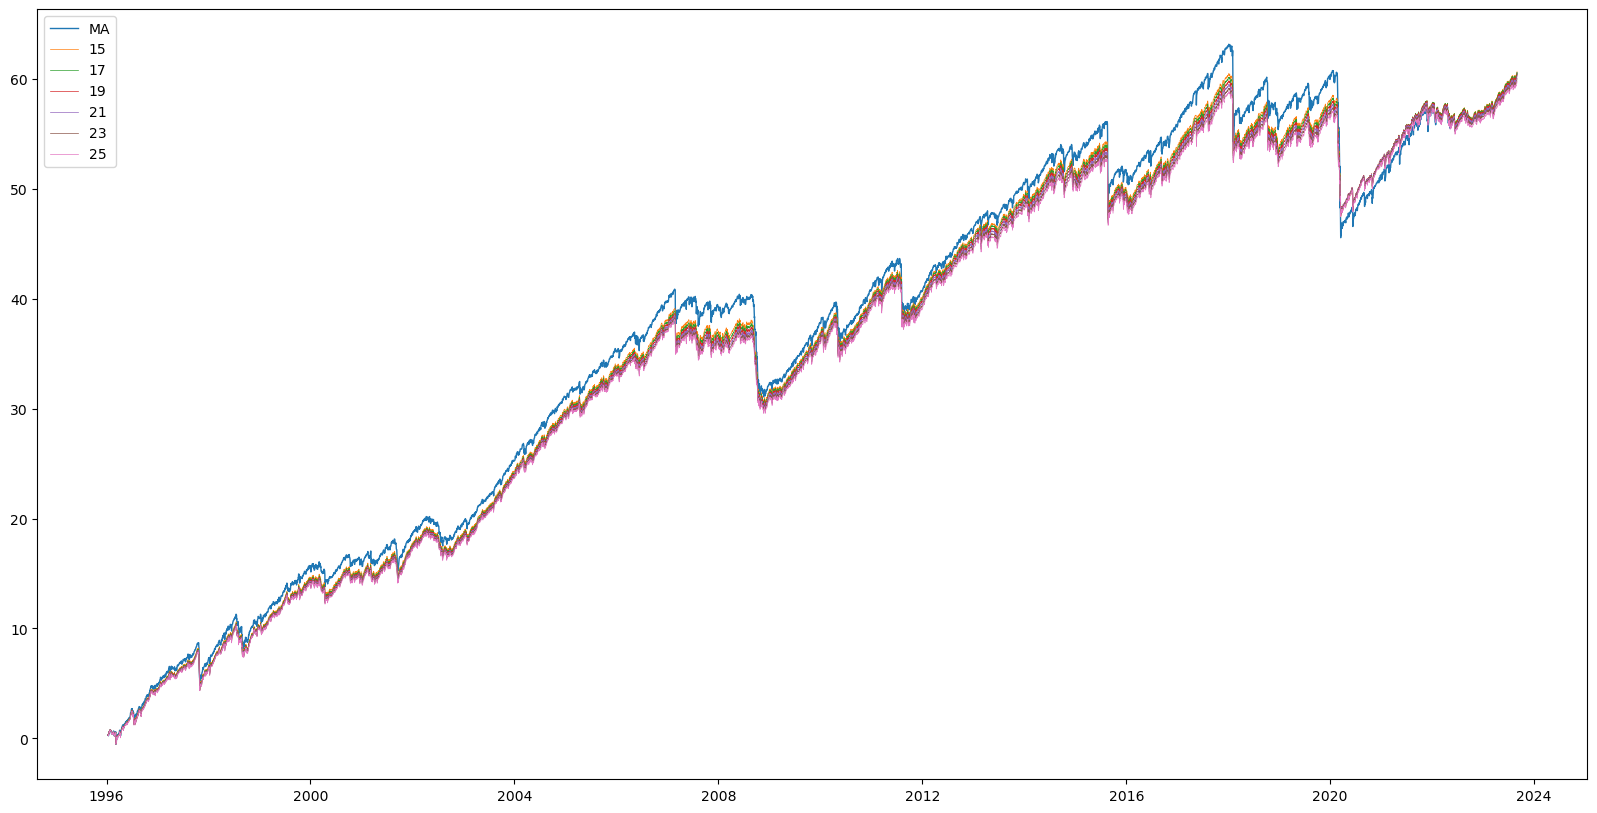

In [124]:
df = orpy[orpy["ticker"]=="SPX"].copy()

plt.figure(figsize = (20,10))

for alpha in np.arange(15,26,2):
    df[alpha] = -np.cumsum(df[f"r_30_SW_day .{alpha}"])
    
df["MA"] = -np.cumsum(df["r_30_SW_day"])

# df = df[df["date"].dt.year >= 2019]

plt.plot(df["date"], df["MA"], label="MA", lw = 1)
# plt.plot(df["date"], -np.cumsum(df["r_30_SW_day old"]), label="old")
    
for alpha in np.arange(15,26,2):
    plt.plot(df["date"], df[alpha], label=alpha, lw=0.5)

plt.legend()
plt.show()